In [1]:
 !pip install -q -U toai

     |████████████████████████████████| 153kB 4.3MB/s 
     |████████████████████████████████| 296kB 43.2MB/s 
     |████████████████████████████████| 81kB 9.5MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 


In [0]:
 !pip install -q kaggle

 !mkdir -p ~/.kaggle
 !cp kaggle.json ~/.kaggle/
 !chmod 600 ~/.kaggle/kaggle.json

In [0]:
 !pip install tensorflow==2.0.0-rc0

In [4]:
from toai.imports import *
from toai.data import Dataset, DataParams, DataContainer, split_df
from toai.models import save_keras_model, load_keras_model
from toai.metrics import sparse_top_2_categorical_accuracy
from toai.image import (
    ImageLearner,
    ImageAugmentor,
    ImageDataset,
    ImageParser,
    ImageResizer,
    LearningRateFinder,
    ImageTrainingCycle,
    ImageTrainer,
)
from toai.utils import download_file, unzip, save_file, load_file
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image
import os
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
DATA_DIR = Path("data/steel")
TEMP_DIR = Path("temp/steel")
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [6]:
 kaggle.api.competition_download_file(
     competition="severstal-steel-defect-detection",
     file_name="train_images.zip",
     path=DATA_DIR,
 )

  0%|          | 0.00/1.16G [00:00<?, ?B/s]

100%|██████████| 1.16G/1.16G [00:18<00:00, 68.9MB/s]

In [7]:
kaggle.api.competition_download_file(
     competition="severstal-steel-defect-detection",
     file_name="train.csv",
     path=DATA_DIR,
 )

  0%|          | 0.00/6.91M [00:00<?, ?B/s]

100%|██████████| 6.91M/6.91M [00:00<00:00, 23.0MB/s]

In [0]:
unzip.all_files_in_dir(DATA_DIR, ".zip")

In [0]:
train_df = pd.read_csv(DATA_DIR/'train.csv')

In [10]:
train_df.head(10)

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN
5,00031f466.jpg_2,NaN
6,00031f466.jpg_3,NaN
7,00031f466.jpg_4,NaN
8,000418bfc.jpg_1,NaN
9,000418bfc.jpg_2,NaN


In [11]:
train_df.describe()

,ImageId_ClassId,EncodedPixels
count,50272,7095
unique,50272,7095
top,b1c892c12.jpg_4,265217 43 265473 128 265729 213 265985 3072 26...
freq,1,1


In [12]:
train_df.shape

(50272, 2)

In [0]:
class_dict = defaultdict(int)

kind_class_dict = defaultdict(int)

no_defects_num = 0
defects_num = 0

for col in range(0, len(train_df), 4):
    img_names = [str(i).split("_")[0] for i in train_df.iloc[col:col+4, 0].values]
         
    labels = train_df.iloc[col:col+4, 1]
    if labels.isna().all():
        no_defects_num += 1
    else:
        defects_num += 1
    
    kind_class_dict[sum(labels.isna().values == False)] += 1
        
    for idx, label in enumerate(labels.isna().values.tolist()):
        if label == False:
            class_dict[idx+1] += 1

Text(0.5, 0, 'class')

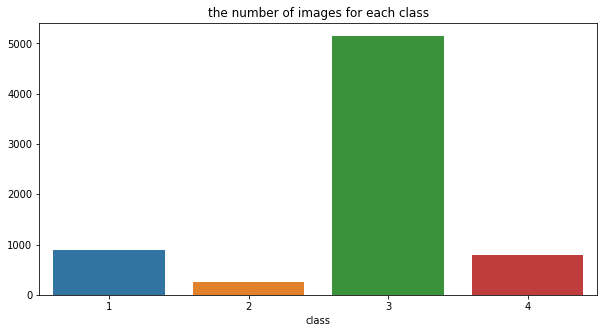

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=list(class_dict.keys()), y=list(class_dict.values()), ax=ax)
ax.set_title("the number of images for each class")
ax.set_xlabel("class")



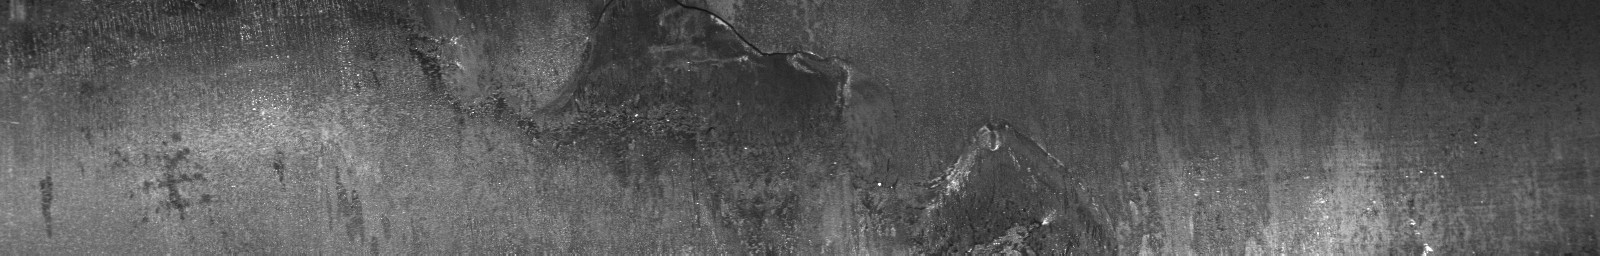

In [0]:
Image(train_df['Path'][27])

In [0]:
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])

In [0]:
#train_df=train_df.drop(columns="ImageId_ClassId")

In [0]:
#train_df['ClassId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])

In [0]:
train_df['Path'] = train_df['ImageId'].map(lambda x: os.path.join(DATA_DIR,'{}'.format(x)))


In [0]:
train_df['Defection'] = train_df['EncodedPixels'].map(lambda x: 0 if x is np.nan else 1)

In [0]:
train_df.head(50)

In [0]:
#train_df = train_df.sample().reset_index(drop=True)

In [0]:
subsampled_train_df=train_df[~train_df.index.isin(train_df[train_df["Defection"] == 3].sample(frac=0.2).index)]

In [0]:
#train_df.ClassId = train_df.ClassId.astype(int)

In [132]:
train_df.head()

,ImageId_ClassId,EncodedPixels,ImageId,Defection,Path
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,data/steel/0002cc93b.jpg
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,0,data/steel/0002cc93b.jpg
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,0,data/steel/0002cc93b.jpg
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,0,data/steel/0002cc93b.jpg
4,00031f466.jpg_1,NaN,00031f466.jpg,0,data/steel/00031f466.jpg


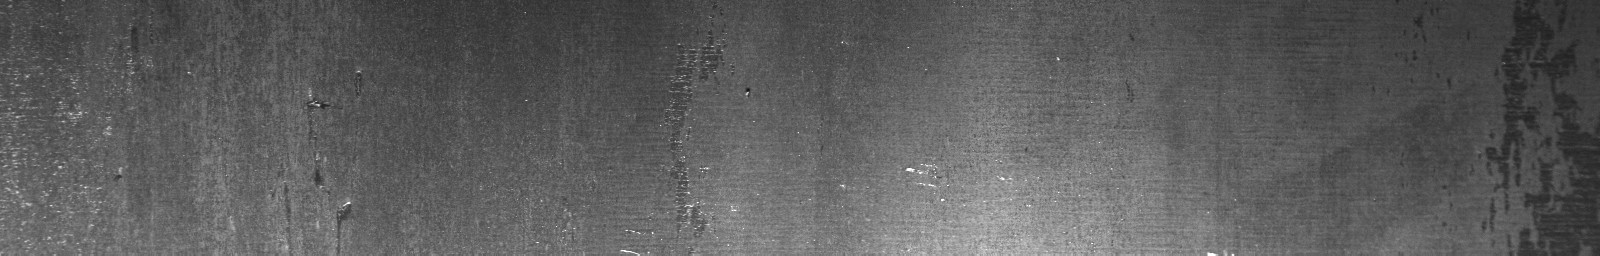

In [0]:
%matplotlib inline
Image(train_df['Path'][0])


In [0]:
#train_df['ClassId'].value_counts()


4    12568
2    12568
3    12568
1    12568
Name: ClassId, dtype: int64

In [0]:
#plt.figure(figsize=(12,4))
#sns.countplot(x='ClassId', data=train_df)
#plt.show()

In [0]:
train_data, valid_data, test_data = ImageDataset.split(
    dataset=ImageDataset.from_dataframe(subsampled_train_df, x_col="Path", y_col='Defection'),
    fracs=(0.2, 0.1, 0.1),
)

In [72]:
len(train_data),len(valid_data),len(test_data)

(10055, 5028, 5028)

In [27]:
train_data.x,train_data.y

(array(['data/steel/6caa89d4e.jpg', 'data/steel/1dd56a824.jpg',
        'data/steel/df4d01acb.jpg', ..., 'data/steel/756e03bd3.jpg',
        'data/steel/662e5a5ee.jpg', 'data/steel/b6db869b7.jpg'],
       dtype=object), array([0, 0, 1, ..., 1, 0, 0]))

In [0]:
IMG_DIMS = (99,99,3)

In [0]:
train_image_dataset = (
    train_data
    .dataset(batch_size=4, img_dims=IMG_DIMS, shuffle=True)
    .make_pipeline(
        image_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="stretch"),
            ImageAugmentor(level=2, flips="horizontal"),
        ],
    )
    .save_pipeline(TEMP_DIR/"train")
    .preprocess()
)

In [0]:
valid_image_dataset = (
    valid_data.dataset(batch_size=4, img_dims=IMG_DIMS, shuffle=False)
    .make_pipeline(
        label_map=train_image_dataset.label_map,
        image_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="stretch"),
        ],
    )
    .save_pipeline(TEMP_DIR / "pred")
    .preprocess()
)

In [32]:
train_df.dtypes

ImageId_ClassId    object
EncodedPixels      object
ImageId            object
Defection           int64
Path               object
dtype: object

In [0]:
test_image_dataset = (
    test_data.dataset(batch_size=4, img_dims=IMG_DIMS, shuffle=False)
    .load_pipeline(TEMP_DIR / "pred")
    .preprocess()
)

In [0]:
data_container = DataContainer(
    train=train_image_dataset, validation=valid_image_dataset, test=test_image_dataset
)

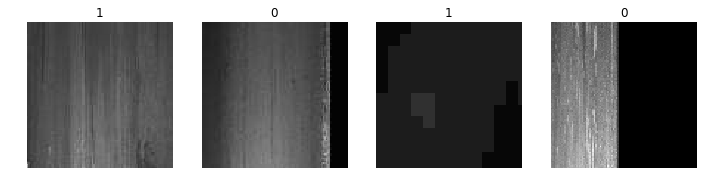

In [42]:
data_container.train.show()

In [0]:
learner = ImageLearner(
    path=TEMP_DIR / "xception",
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    output_shape=[data_container.train.n_classes],
    activation=keras.activations.softmax,
    loss=keras.losses.sparse_categorical_crossentropy, 
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
    dropout=0.1,
    l1=3e-6,
    l2=3e-5,
    override=True,
)

In [36]:
learner.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 99, 99, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 49, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [0]:
trainer = ImageTrainer(learner=learner, data_container=data_container)

In [0]:
cycles = [
    ImageTrainingCycle(
        n_epochs=2,
        lr=3e-4,
        optimizer=keras.optimizers.Adam,
        freeze=True,
        feature_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="stretch"),
            ImageAugmentor(level=3),
        ],
    ),
    ImageTrainingCycle(
        n_epochs=2,
        lr=3e-5,
        optimizer=keras.optimizers.Adam,
        feature_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="stretch"),
            ImageAugmentor(level=2, flips="horizontal"),
        ],
    ),
    ImageTrainingCycle(
        n_epochs=2,
        lr=1e-5,
        optimizer=keras.optimizers.SGD,
        feature_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="stretch"),
            ImageAugmentor(level=3),
        ],
    ),
]

In [40]:
trainer.train(cycles=cycles)

Train for 2514 steps, validate for 1257 steps
Epoch 1/2
2514/2514 [==============================] - 1032s 411ms/step - loss: 0.4851 - sparse_categorical_accuracy: 0.8480 - sparse_top_2_categorical_accuracy: 1.0000 - val_loss: 0.5453 - val_sparse_categorical_accuracy: 0.7908 - val_sparse_top_2_categorical_accuracy: 1.0000
Epoch 2/2
2514/2514 [==============================] - 942s 375ms/step - loss: 0.4500 - sparse_categorical_accuracy: 0.8505 - sparse_top_2_categorical_accuracy: 1.0000 - val_loss: 0.5192 - val_sparse_categorical_accuracy: 0.8025 - val_sparse_top_2_categorical_accuracy: 1.0000
Train for 2514 steps, validate for 1257 steps
Epoch 1/2
  69/2514 [..............................] - ETA: 1:14:41 - loss: 0.9942 - sparse_categorical_accuracy: 0.6250 - sparse_top_2_categorical_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_loss available, skipping.


KeyboardInterrupt: ignored

In [0]:
n_classes = 2

In [0]:
learner.squeeze_layer = keras.layers.Dense(
    8,
    activation=keras.activations.relu,
    kernel_initializer=keras.initializers.he_uniform(),
)
learner.output_layer = keras.layers.Dense(
    n_classes, activation=keras.activations.softmax
)

In [51]:
learner.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 99, 99, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 49, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [0]:
learner.model = keras.Model(
    inputs=learner.base_model.input,
    outputs=learner.output_layer(learner.squeeze_layer(learner.dropout_layer)),
)

In [53]:
learner.model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 99, 99, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 49, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [54]:
trainer.train(cycles=cycles)

Train for 2514 steps, validate for 1257 steps
Epoch 1/2
2514/2514 [==============================] - 1051s 418ms/step - loss: 0.5273 - sparse_categorical_accuracy: 0.7885 - sparse_top_2_categorical_accuracy: 1.0000 - val_loss: 0.4381 - val_sparse_categorical_accuracy: 0.8638 - val_sparse_top_2_categorical_accuracy: 1.0000
Epoch 2/2
2514/2514 [==============================] - 1001s 398ms/step - loss: 0.4212 - sparse_categorical_accuracy: 0.8624 - sparse_top_2_categorical_accuracy: 1.0000 - val_loss: 0.4097 - val_sparse_categorical_accuracy: 0.8638 - val_sparse_top_2_categorical_accuracy: 1.0000
Train for 2514 steps, validate for 1257 steps
Epoch 1/2
  26/2514 [..............................] - ETA: 2:23:27 - loss: 0.4529 - sparse_categorical_accuracy: 0.8700 - sparse_top_2_categorical_accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_loss available, skipping.


KeyboardInterrupt: ignored

In [0]:
learner.model = keras.Model(
    inputs=learner.base_model.input,
    outputs=learner.squeeze_layer(learner.dropout_layer),
)

In [56]:
learner.model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 99, 99, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 49, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [0]:
learner.model = keras.Model(
    inputs=learner.base_model.input, outputs=learner.concat_layer
)

In [0]:
def show_distances(
    dataset,
    target_index,
    similar_indices,
    distances,
    cols: int = 4,
    debug: bool = False,
):
    if cols >= len(distances) + 1:
        cols = len(distances) + 1
        rows = 1
    else:
        rows = math.ceil((len(distances) + 1) / cols)

    figsize = (3 * cols, 4 * rows) if debug else (3 * cols, 3 * rows)
    _, ax = plt.subplots(rows, cols, figsize=figsize)

    for i, (x, y, distance) in enumerate(
        zip(
            dataset.x[[target_index] + similar_indices],
            dataset.y[[target_index] + similar_indices],
            [0] + distances,
        )
    ):
        idx = (i // cols, i % cols) if rows > 1 else i % cols
        ax[idx].axis("off")
        ax[idx].imshow(Image.open(x))
        title = f"Label: {y}\nShape: {x.shape}\n" if debug else f"{y}\n{distance:.2f}"
        ax[idx].set_title(title)

In [0]:
image_embeddings = learner.predict(
    pipeline=data_container.train.image_pipeline, image_paths=data_container.train.x
)

In [0]:
 neighbors= sk.neighbors.NearestNeighbors(n_neighbors=11, algorithm="ball_tree").fit(
    image_embeddings
)

In [121]:
new_image_index = np.random.randint(len(data_container.train))
new_image_index

4973

In [0]:
new_image_embeddings = learner.predict(
    pipeline=data_container.train.image_pipeline,
    image_paths=data_container.train.x[new_image_index : new_image_index + 1],
)

In [0]:
distances, indices = neighbors.kneighbors(new_image_embeddings)

AttributeError: ignored

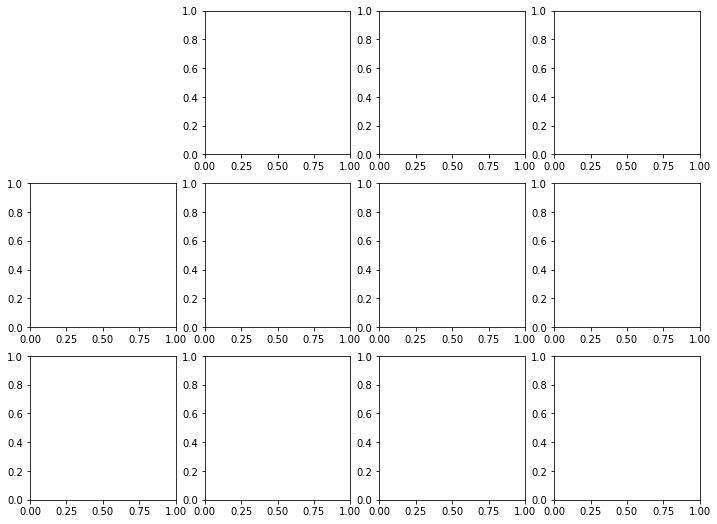

In [140]:
show_distances(
    data_container.train, new_image_index, indices[0].tolist(), distances[0].tolist())

In [73]:
len(train_data),len(valid_data),len(test_data)

(10055, 5028, 5028)